# U-Net - Classification
### Classification layers connected to the first half of the U-Net

In [1]:
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread
from skimage.transform import resize
from skimage.measure import label, regionprops
from skimage.util import random_noise

from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import tensorflow as tf

## 1. Experiment setup and the HParams experiment summary

Experiment with three hyperparameters in the model:

1. Number of channels (1x or 2x)
2. Learning rate
3. Batch size
4. Epochs
5. Picture size
6. (Optimizer)

In [2]:
date = "24_05_18"

In [3]:
def display(display_list):
  plt.figure(figsize=(8, 8))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i == 1:
      plt.imshow(display_list[i], cmap='gray',  interpolation='nearest')
    elif i == 2:
      plt.imshow(display_list[i], cmap='jet',  interpolation='nearest')
    else:
      plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [4]:
hyper_param_channels = 2
hyper_param_learning_rate = 0.001
hyper_param_batch_size = 100
hyper_param_epochs = 70
hyper_param_image_size = 1

#image dimensions, seems to work with non-square inputs
IMAGE_CHANNELS = 3
IMAGE_HEIGHT =  192*hyper_param_image_size
IMAGE_WIDTH = 64*hyper_param_image_size

seed = 4
np.random.seed = seed
random.seed(seed)
tf.random.set_seed(seed)

DATA_TRAIN = "./datasets/KolektorSDD2/train/"
DATA_TEST = "./datasets/KolektorSDD2/test/"

train_ids = next(os.walk(os.path.join(DATA_TRAIN, "images/")))[2]
test_ids = next(os.walk(os.path.join(DATA_TEST, "images/")))[2]

damaged = [] # prepare for data augmentation
damaged_mask = []

X_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.float16)
y_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.float16)

print('Resizing training images and masks')

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = DATA_TRAIN 

    img = imread(path + 'images/' + id_)[:,:,:IMAGE_CHANNELS]  
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    img /= 255.0
    X_train[n] = img  #Fill empty X_train with values from img

    mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=bool)
    mask_file = os.path.join(path + 'masks/' + id_[:5] + "_GT.png")
    mask = imread(mask_file)[:,:]

    mask = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    mask /= 255.0  
    mask = np.where(mask > 0.5, 1.0, 0.0) 
    y_train[n] = mask 

    if np.count_nonzero(mask) != 0:
        damaged.append(img)
        damaged_mask.append(mask)
    
# test images
test_images = np.zeros((len(test_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.float16)
test_masks = np.zeros((len(test_ids), IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.float16)

sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = DATA_TEST
    img = imread(path + '/images/' + id_ )[:,:,:IMAGE_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    img /= 255.0
    test_images[n] = img

    mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=bool)
    mask_file = os.path.join(path + 'masks/' + id_[:5] + "_GT.png")
    mask = imread(mask_file)[:,:]

    mask = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    mask /= 255.0     
    mask = np.where(mask > 0.5, 1.0, 0.0)   
    test_masks[n] = mask 

## Data augmentation - rotate and flip images
vertical_train = np.flip(damaged, axis=0)
vertical_test = np.flip(damaged_mask, axis=0)

horizontal_train = np.flip(damaged, axis=1)
horizontal_test = np.flip(damaged_mask, axis=1)

rotating_train = np.rot90(damaged, k=2)
rotating_test = np.rot90(damaged_mask, k=2)

vert_rot_train = np.rot90(vertical_train, k=2)
vert_rot_test = np.rot90(vertical_test, k=2)

hor_rot_train = np.rot90(horizontal_train, k=2)
hor_rot_test = np.rot90(horizontal_test, k=2)

# Done with rotation
Boxes = []
check = []
for img in damaged_mask:
    labels = label(img)
    regions = regionprops(labels)
    if len(regions) == 1:
        check.append(1)
        for props in regions:
            min_x, min_y, max_x, max_y = props.bbox
            Boxes.append((min_x, min_y, max_x, max_y))
    else:
        check.append(0)

# Throw out images, which have more than one damage
onedamage = [damaged[i] for i in range(len(damaged)) if check[i] == 1]
onedamage_mask = [damaged_mask[i] for i in range(len(damaged_mask)) if check[i] == 1]

def crop_image(image, bbox):
    # Crop the image using NumPy array slicing
    cropped_image = image[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    return cropped_image

def overlay_image(background, background_mask, overlay, overlay_mask):
    # Generate random position for overlay image
    if overlay.shape[1] < background.shape[1]:
        x_offset = np.random.randint(0, background.shape[1] - overlay.shape[1])
        y_offset = np.random.randint(0, background.shape[0] - overlay.shape[0])
    
        # Overlay the image
        background[y_offset:y_offset + overlay.shape[0], x_offset:x_offset + overlay.shape[1]] = overlay
        background_mask[y_offset:y_offset + overlay_mask.shape[0], x_offset:x_offset + overlay_mask.shape[1]] = overlay_mask
        return background, background_mask
    else:
        return background, background_mask

generated_img = np.empty((len(onedamage),IMAGE_HEIGHT,IMAGE_WIDTH,3))
generated_mask = np.empty((len(onedamage), IMAGE_HEIGHT,IMAGE_WIDTH))
overlayed_indices = []
for i, image in enumerate(onedamage):
    # Get the bounding box for the current image
    bbox = Boxes[i]
    mask = onedamage_mask[i]
    # Crop the image
    cropped_image = crop_image(image, bbox)
    cropped_mask = crop_image(mask, bbox)
    # Pick a random overlay image from the list
    overlay_image_index = np.random.choice([idx for idx in range(len(X_train)) if idx not in overlayed_indices])
    overlay = X_train[overlay_image_index]
    overlay_mask = y_train[overlay_image_index]

    # Overlay the cropped image onto the random overlay image
    new_image, new_mask = overlay_image(overlay, overlay_mask, cropped_image, cropped_mask)
    generated_img[i] = new_image
    generated_mask[i] = new_mask
    overlayed_indices.append(overlay_image_index)

noised = np.empty_like(damaged)
noised_mask = damaged_mask
i = 0
for img in damaged:
    noise = random_noise(img, mode='gaussian', rng=seed, clip=True)
    noised[i] = noise
    i = i+1

noised_vert = np.empty_like(damaged)
noised_mask_vert = vertical_test
i = 0
for img in vertical_train:
    noise = random_noise(img, mode='gaussian', rng=seed, clip=True)
    noised_vert[i] = noise
    i = i+1

noised_horr = np.empty_like(damaged)
noised_mask_horr = horizontal_test
i = 0
for img in horizontal_train:
    noise = random_noise(img, mode='gaussian', rng=seed, clip=True)
    noised_horr[i] = noise
    i = i+1

X_train = np.concatenate((vertical_train, horizontal_train, rotating_train, vert_rot_train, hor_rot_train, X_train)) #, noised, noised_vert, noised_horr, generated_img))
y_train = np.concatenate((vertical_test, horizontal_test, rotating_test, vert_rot_test, hor_rot_test, y_train)) #, noised_mask, noised_mask_vert, noised_mask_horr, generated_mask))

print('Dataset is ready')

unique, counts = np.unique(y_train, return_counts=True)

print(dict(zip(unique, counts)))
print("Percentage of faulty images in train data:", counts[1]/(counts[0]+counts[1])*100, " %")
neg = counts[0]
pos = counts[1]

initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)




Resizing training images and masks


100%|██████████| 2332/2332 [01:19<00:00, 29.39it/s]


Resizing test images


100%|██████████| 1004/1004 [00:34<00:00, 28.74it/s]


Dataset is ready
558213
{0.0: 43273083, 1.0: 558213}
Percentage of faulty images in train data: 1.2735489272322682  %


In [5]:
y_train_bin = np.array([1 if np.count_nonzero(element) != 0 else 0 for element in y_train])
y_val_bin = np.array([1 if np.count_nonzero(element) != 0 else 0 for element in y_val])
test_masks_bin = np.array([1 if np.count_nonzero(element) != 0 else 0 for element in test_masks])

In [7]:
# Load pretrained model
trained_model = tf.keras.models.load_model('./trainedModels/hptuning_24_04_20/hptuning_session0.h5')

# Select first 13 layers
selected_layers = trained_model.layers[:13]

# Disable training for pretrained layers
# selected_layers.trainable = False

# Create a new model with selected layers
model = tf.keras.models.Sequential(selected_layers)

# Add additional layers
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="maxpooling_5"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

for layer in model.layers[:13]:
    layer.trainable = False

from keras.optimizers import Adam
optimizer = Adam(learning_rate = hyper_param_learning_rate)

#Compiling model
model.compile(optimizer=optimizer , loss='binary_crossentropy', metrics=['accuracy']) #TODO: Parameters check #metrics.BinaryIoU()
model.summary()

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25, restore_best_weights=True)

epochs = hyper_param_epochs  
batch_size = hyper_param_batch_size

# Fitting the model
history = model.fit(X_train, 
                    y_train_bin, 
                    epochs = epochs, 
                    validation_data = (X_val, y_val_bin), 
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    callbacks=[early_stopping],
                    batch_size = batch_size,) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 64, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 64, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 16, 64)       0         
 2D)                                                    

In [8]:
# layers_list = []
# for layer in trained_model.layers:
#     layers_list.append(layer.name)
#     print(layer.output)
#     # print(layer.name)

# print(layers_list)

32/32 [==============================] - 0s 9ms/step


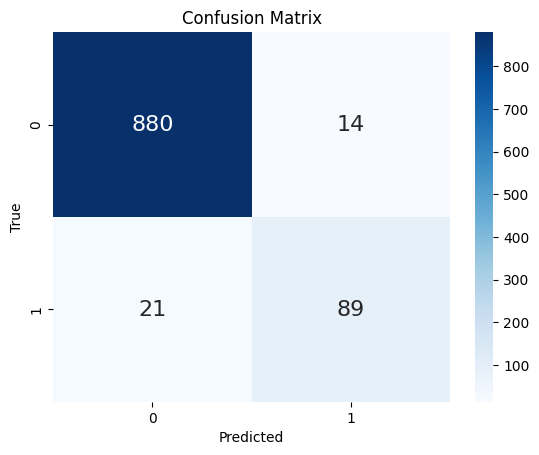

Accuracy: 96.51%
Precision: 0.8641
Recall: 0.8091
F1 Score: 0.8357


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

threshold = 0.75

Y_pred = model.predict(test_images)
Y_pred_bin_list = []
for val in Y_pred:
    if val > threshold:
        Y_pred_bin_list.append(1)
    else:
        Y_pred_bin_list.append(0)
Y_pred_bin = np.array(Y_pred_bin_list)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_masks_bin, Y_pred_bin)

# Display the confusion matrix using a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Additional metrics
accuracy = accuracy_score(test_masks_bin, Y_pred_bin)
precision = precision_score(test_masks_bin, Y_pred_bin)
recall = recall_score(test_masks_bin, Y_pred_bin)
f1 = f1_score(test_masks_bin, Y_pred_bin)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
%tensorboard --logdir logs/hparam_tuning_24_04_17

UsageError: Line magic function `%tensorboard` not found.
